In [364]:
import numpy as np
import DeeperDream as dd
from DeeperDream.Activation.Class import *
from matplotlib import pyplot as plt

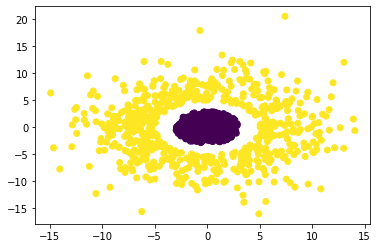

In [365]:
def Donut(n, r, margin):
    x = np.random.randn(n, 2)
    x_donut = x[np.sqrt(np.sum(x ** 2, axis=1)) > 1] * (r + margin / 2)
    x_hole = x[np.sqrt(np.sum(x ** 2, axis=1)) <= 1] * (r - margin / 2)

    y_hole = np.zeros([x_hole.shape[0], 1])
    y_donut = np.ones([x_donut.shape[0], 1])

    x = np.vstack([x_hole, x_donut])
    y = np.vstack([y_hole, y_donut])
    return x, y

x,y = Donut(1000, 4, 2)
plt.scatter(x[:,[0]],x[:,[1]],c=y)

In [366]:
class Base_Layer:
    """
    Superclass for all of the layers.

    Contains methods for connecting layers together.
    """
    def __init__(self):
        self.end = self
        self.after = None

    def AddAfter(self, layer):
        self.end.after = layer
        self.end = layer
        return self

    def __rshift__(self, other):
        """
        Wrapper for self.AddAfter()

        Allows us to use the >> operator for constructing our models.

        Example - A simple two layer model with an input shape of 2 and an output shape of 4:
            Layer(2, 3) >> Layer(3, 4)

        :param layer: The next layer in the model; the current layer will feed into this
        :return: self
        """
        return self.AddAfter(other)


class Layer(Base_Layer):
    def __init__(self, size_in, size_out, activation_func=Sigmoid(), learn_rate=1e-3, batch_norm_p=None):
        super().__init__()
        self.w = { "array": np.random.randn(size_in, size_out) * np.sqrt(1 / (size_in + size_out)), "grad" : 0 }
        self.b = { "array" : np.random.randn(1, size_out) * np.sqrt(1 / (size_in + size_out)), "grad" : 0 }
        self.activation_func = activation_func
        self.learn_rate = learn_rate
        self.batch_norm_p = batch_norm_p
        self.mu_h = 0
        self.sig_h = 1

    def Forward(self, z_in):
        h = z_in @ self.w["array"] + self.b["array"]
        if self.batch_norm_p:
            mu_h = np.mean(h, keepdims=True, axis=0)
            self.mu_h = self.mu_h * self.batch_norm_p + mu_h * (1 - self.batch_norm_p)
            sig_h = np.std(h, keepdims=True, axis=0)
            self.sig_h = self.sig_h * self.batch_norm_p + sig_h * (1 - self.batch_norm_p)
        h_norm = (h - self.mu_h) / self.sig_h
        z_out = self.activation_func(h_norm)
        return z_out

    def Backward(self, z_in, y):
        h = z_in @ self.w['array'] + self.b['array']
        if self.batch_norm_p:
            mu_h = np.mean(h, keepdims=True, axis=0)
            self.mu_h = self.mu_h * self.batch_norm_p + mu_h * (1 - self.batch_norm_p)
            sig_h = np.std(h, keepdims=True, axis=0)
            self.sig_h = self.sig_h * self.batch_norm_p + sig_h * (1 - self.batch_norm_p)
        h_norm = (h - self.mu_h) / (self.sig_h + 1e-99)
        z_out = self.activation_func(h_norm)

        grad_after = self.after.Backward(z_out, y)
        grad_h_norm = grad_after * self.activation_func.D(h_norm)
        grad_h = grad_h_norm / self.sig_h

        self.w['grad'] = z_in.T @ grad_h
        self.b['grad'] = np.sum(grad_h, axis=0)
        grad_z_in = grad_h @ self.w['array'].T

        return grad_z_in

    def Predict(self, z_in):
        h = z_in @ self.w['array'] + self.b['array']
        if self.batch_norm_p:
            mu_h = np.mean(h, keepdims=True, axis=0)
            sig_h = np.std(h, keepdims=True, axis=0)
            h = (h - mu_h) / (sig_h + 1e-99)
        
        z_out = self.activation_func(h)

        return self.after.Predict(z_out)

    def GetParameters(self):
        after_params = self.after.GetParameters()
        self_params = [self.w, self.b]
        self_params.extend(after_params)
        return self_params



In [367]:
class Output_Layer(Layer):
    def Backward(self, z_in, y):
        y_hat = self.Forward(z_in)
        grad_h = y_hat - y

        self.w['grad'] = z_in.T @ grad_h
        self.b['grad'] = np.sum(grad_h, axis=0)
        grad_z_in = grad_h @ self.w['array'].T

        return grad_z_in

    def Predict(self, z_in):
        return self.Forward(z_in)

    def GetParameters(self):
        return [self.w, self.b]

In [368]:
class Batch_Norm(Base_Layer):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.mu = 0
        self.std = 1

    def Forward(self, z_in):
        self.mu = self.mu * self.p + np.mean(z_in, axis=0, keepdims=True) * (1 - self.p)
        self.std = self.std * self.p + np.std(z_in, axis=0, keepdims=True) * (1 - self.p)
        z_out = (z_in - self.mu) / (self.std + 1e-99)
        return z_out

    def Backward(self, z_in, y):
        z_out = self.Forward(z_in)

        grad_after = self.after.Backward(z_out,y)
        grad_out = 1 / self.std * grad_after

        return grad_out

    def Predict(self, z_in):
        mu = np.mean(z_in,axis=0,keepdims=True)
        std = np.std(z_in,axis=0,keepdims=True)
        z_out = (z_in - mu) / (std + 1e-99)
        return self.after.Predict(z_out) 

    def GetParameters(self):
        return self.after.GetParameters()

In [369]:
model = Layer(2,8) >> Batch_Norm(0.7) >> Output_Layer(8,1)

In [370]:
params = model.GetParameters()
params

[{'array': array([[-0.23420242,  0.19393866,  0.05300771, -0.09541289, -0.74596919,
          -0.41129464, -0.07316058,  0.18773422],
         [ 0.07943984,  0.10006319, -0.47247252,  0.21533345, -0.03179059,
           0.44125201, -0.04340137,  0.49445675]]), 'grad': 0},
 {'array': array([[ 0.39396498, -0.3297424 ,  0.30202234,  0.18315991, -0.07601724,
          -0.44278414, -0.21722851, -0.41846913]]),
  'grad': 0},
 {'array': array([[ 0.02530873],
         [ 0.322886  ],
         [ 0.29149296],
         [ 0.0983074 ],
         [-0.31299966],
         [-0.44142029],
         [ 0.77092414],
         [ 0.0125516 ]]), 'grad': 0},
 {'array': array([[-0.26106701]]), 'grad': 0}]

In [371]:
class SGD:
    def __init__(self, parameters, learn_rate = 1e-4):
        self.lr = learn_rate
        self.parameters = parameters

    def UpdateWeights(self):
        for param in self.parameters:
            param['array'] -= param['grad'] * self.lr

In [372]:
optim = SGD(params)
iterations = 1000
for i in range(iterations):
    model.Backward(x,y)
    optim.UpdateWeights()

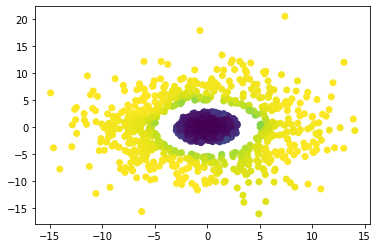

In [373]:
y_hat = model.Predict(x)
plt.scatter(x[:,[0]],x[:,[1]],c=y_hat)

In [374]:
class NumpyList:
        def __init__(self, ls):
            self.ls = ls

        def __add__(self, other):
            return NumpyList([arr1 + arr2 for arr1,arr2 in zip(self.ls, other)])
        def __sub__(self, other):
            return NumpyList([arr1 - arr2 for arr1,arr2 in zip(self.ls, other)])
        def __mul__(self, other):
            return NumpyList([arr1 * arr2 for arr1,arr2 in zip(self.ls, other)])
        def __truediv__(self, other):
            return NumpyList([arr1 / arr2 for arr1,arr2 in zip(self.ls, other)])

        def __iadd__(self, other):
            for i,arr in enumerate(other):
                self.ls[i] += arr
        def __isub__(self, other):
            for i,arr in enumerate(other):
                self.ls[i] -= arr
        def __imul__(self, other):
            for i,arr in enumerate(other):
                self.ls[i] *= arr
        def __idiv__(self, other):
            for i,arr in enumerate(other):
                self.ls[i] /= arr

        def __getitem__(self, item):
            return self.ls[item]

        def __str__(self):
            # string = ""
            # for arr in self.ls:
            #     string += (str(arr) + ",")
            return str(self.ls)

        def _repr_pretty_(self, p, cycle=False):
            p.text(str(self.ls))


class Parameters:
    def __init__(self, weights, grads=None):
        if not grads:
            grads = [np.zeros_like(w) for w in weights]
        self.weights = NumpyList(weights)
        self.grads = NumpyList(grads)
        self.__dict__ = { 'array' : self.weights, 'grad' : self.grads}

    def __getitem__(self,item):
        return self.__dict__[item]

    def __setitem__(self,key,value):
        self.__dict__[key] = value
        
    def __str__(self):
        return str(self.__dict__)

    def _repr_pretty_(self, p, cycle=False):
        p.text(str(self.__dict__))

In [375]:
model2 = Layer(2,8) >> Batch_Norm(0.7) >> Output_Layer(8,1)
p = model2.GetParameters()
params2 = []
for w in p:
    params2.append(w['array'])
p = Parameters(params2)
p['array']

[array([[ 0.20554081,  0.32672161, -0.13604501,  0.2798079 ,  0.21427203,
        -0.15182458,  0.11597319, -0.25547805],
       [ 0.40329411,  0.26555134,  0.54012975,  0.11772806, -0.04323823,
        -0.33585316, -0.08987369,  0.61867209]]), array([[ 0.22087369,  0.06216349,  0.84483003, -0.06104176, -0.23118522,
         0.12424574,  0.30379206, -0.09402902]]), array([[ 0.5573043 ],
       [ 0.12782245],
       [ 0.34839768],
       [-0.43349455],
       [-0.15171875],
       [-0.16731652],
       [-0.4770836 ],
       [-0.12528066]]), array([[0.14310458]])]

In [376]:
class SGD2:
    def __init__(self, parameters, learn_rate = 1e-4):
        self.lr = learn_rate
        self.parameters = parameters
        #print(self.parameters['array'])

    def UpdateWeights(self, parameters):
        #print(self.parameters['array'])
        parameters['array'] -= parameters['grad']

In [378]:
optim2 = SGD2(p)
for i in range(iterations):
    model.Backward(x,y)
    optim2.UpdateWeights(p)

TypeError: unsupported operand type(s) for -=: 'NoneType' and 'NumpyList'